In [ ]:
#install not pre-installed necessary packages
!pip install ucimlrepo;
!pip install catboost;
!pip install shap;
!pip install optuna;
!pip install pydataset;
# 1st import of necessary packages
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, classification_report, make_scorer, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, make_scorer, precision_score, recall_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras import models, layers, optimizers
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle
import shap
import warnings
from sklearn.datasets import load_digits,load_iris,load_breast_cancer
warnings.filterwarnings('ignore')
# fetch dataset
adult = fetch_ucirepo(id=2)



# Cross Validtaion

In [ ]:
# Generating synthetic dataset
def generate_data(samples, features=2, random_state=42):
    np.random.seed(random_state)
    X = np.random.randn(samples, features)
    coef = np.random.randn(features)
    logits = X @ coef + np.random.randn(samples) * 0.5
    y = (logits > 0).astype(int)
    return X, y

# Function to evaluate bias and variance
def evaluate_model(X, y, model, cv_method):
    scores = cross_val_score(model, X, y, cv=cv_method, scoring='accuracy')
    bias = 1 - np.mean(scores)
    variance = np.var(scores)
    return bias, variance

# Datasets and splits
sample_sizes = [50, 100, 150, 200, 500]
cv_methods = {
    "5-Fold": KFold(n_splits=5, shuffle=True, random_state=42),
    "10-Fold": KFold(n_splits=10, shuffle=True, random_state=42),
    "LOOCV": LeaveOneOut()
}

# Logistic Regression Model
model = LogisticRegression()

# Initializing results in a dictionary
results = {size: {method: {'bias': None, 'variance': None} for method in cv_methods} for size in sample_sizes}

# Evaluating each dataset with each CV method

for size in sample_sizes:
    X, y = generate_data(samples=size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    for method_name, cv_method in cv_methods.items():
        bias, variance = evaluate_model(X_train, y_train, model, cv_method)
        results[size][method_name]['bias'] = bias
        results[size][method_name]['variance'] = variance

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for method_name in cv_methods:
    biases = [results[size][method_name]['bias'] for size in sample_sizes]
    variances = [results[size][method_name]['variance'] for size in sample_sizes]

    axes[0].plot(sample_sizes, biases, label=method_name)
    axes[1].plot(sample_sizes, variances, label=method_name)

axes[0].set_title('Bias Across Sample Sizes')
axes[0].set_xlabel('Sample Size')
axes[0].set_ylabel('Bias')
axes[0].legend()

axes[1].set_title('Variance Across Sample Sizes')
axes[1].set_xlabel('Sample Size')
axes[1].set_ylabel('Variance')
axes[1].legend()

initiated datasets repo at: /root/.pydataset/


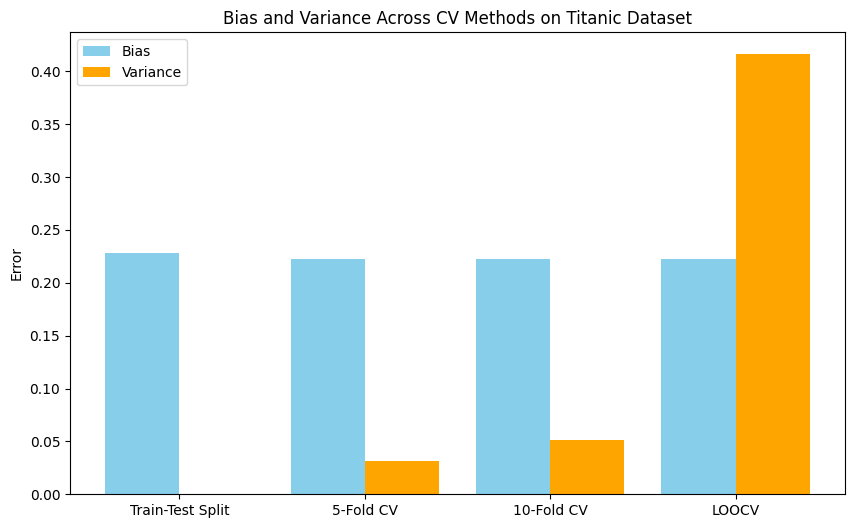

             Method      Bias  Variance
0  Train-Test Split  0.227848  0.000000
1         5-Fold CV  0.222658  0.031406
2        10-Fold CV  0.222658  0.051126
3             LOOCV  0.222644  0.416021


In [ ]:
#Titanic dataset analysis
from pydataset import data

titanic = data('titanic')
titanic = pd.get_dummies(titanic, drop_first=True)

# Features and target variable
X = titanic.drop('survived_yes', axis=1)
y = titanic['survived_yes']

# Defining Logistic Regression model
LogReg = LogisticRegression(solver='lbfgs', max_iter=1000)

# Storing results for bias and variance
results = {'Method': [], 'Bias': [], 'Variance': []}

# Train-Test Split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)
LogReg.fit(X_train, y_train)
test_accuracy = LogReg.score(X_test, y_test)
results['Method'].append('Train-Test Split')
results['Bias'].append(1 - test_accuracy)  # Error = 1 - accuracy
results['Variance'].append(0)

# 5-Fold Cross-Validation
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
scores_5fold = cross_val_score(LogReg, X, y, cv=kf5)
results['Method'].append('5-Fold CV')
results['Bias'].append(1 - scores_5fold.mean())
results['Variance'].append(scores_5fold.std())

# 10-Fold Cross-Validation
kf10 = KFold(n_splits=10, shuffle=True, random_state=42)
scores_10fold = cross_val_score(LogReg, X, y, cv=kf10)
results['Method'].append('10-Fold CV')
results['Bias'].append(1 - scores_10fold.mean())
results['Variance'].append(scores_10fold.std())

# Leave-One-Out Cross-Validation (LOOCV)
loo = LeaveOneOut()
scores_loo = cross_val_score(LogReg, X, y, cv=loo)
results['Method'].append('LOOCV')
results['Bias'].append(1 - scores_loo.mean())
results['Variance'].append(scores_loo.std())

# Converting results to DataFrame
results_df = pd.DataFrame(results)

# Ploting bias and variance
plt.figure(figsize=(10, 6))
x = np.arange(len(results['Method']))
width = 0.4
plt.bar(x - width/2, results['Bias'], width, label='Bias', color='skyblue')
plt.bar(x + width/2, results['Variance'], width, label='Variance', color='orange')
plt.xticks(x, results['Method'])
plt.ylabel('Error')
plt.title('Bias and Variance Across CV Methods on Titanic Dataset')
plt.legend()
plt.show()

# Displaying results
print(results_df)


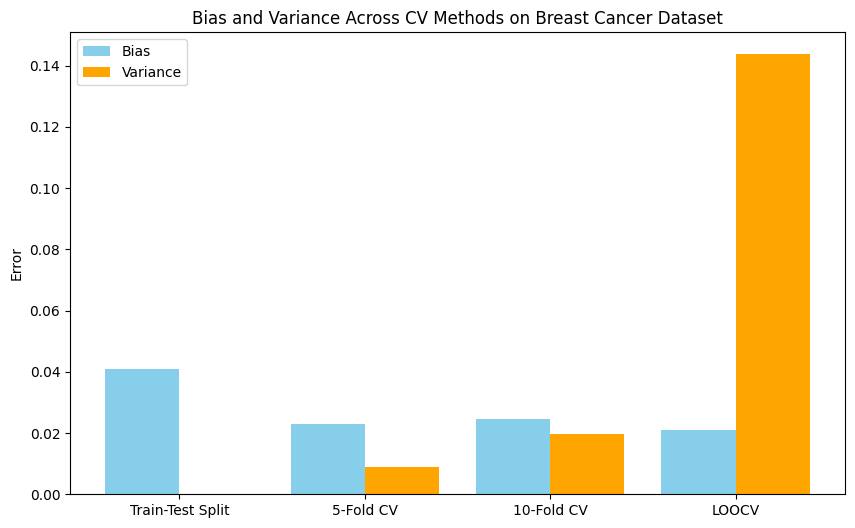

             Method      Bias  Variance
0  Train-Test Split  0.040936  0.000000
1         5-Fold CV  0.022854  0.008964
2        10-Fold CV  0.024593  0.019525
3             LOOCV  0.021090  0.143683


In [ ]:
# Loading Breast Cancer dataset
data = load_breast_cancer()

# Features and target variable
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Standard Scaler
scaler = StandardScaler()

# Scaling the features
X_scaled = scaler.fit_transform(X)

# Defining Logistic Regression model
LogReg = LogisticRegression(solver='lbfgs', max_iter=1000)

# Storing results for bias and variance
results = {'Method': [], 'Bias': [], 'Variance': []}

# Train-Test Split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=15)
LogReg.fit(X_train, y_train)
test_accuracy = LogReg.score(X_test, y_test)
results['Method'].append('Train-Test Split')
results['Bias'].append(1 - test_accuracy)  # Error = 1 - accuracy
results['Variance'].append(0)

# 5-Fold Cross-Validation
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
scores_5fold = cross_val_score(LogReg, X_scaled, y, cv=kf5)
results['Method'].append('5-Fold CV')
results['Bias'].append(1 - scores_5fold.mean())
results['Variance'].append(scores_5fold.std())

# 10-Fold Cross-Validation
kf10 = KFold(n_splits=10, shuffle=True, random_state=42)
scores_10fold = cross_val_score(LogReg, X_scaled, y, cv=kf10)
results['Method'].append('10-Fold CV')
results['Bias'].append(1 - scores_10fold.mean())
results['Variance'].append(scores_10fold.std())

# Leave-One-Out Cross-Validation (LOOCV)
loo = LeaveOneOut()
scores_loo = cross_val_score(LogReg, X_scaled, y, cv=loo)
results['Method'].append('LOOCV')
results['Bias'].append(1 - scores_loo.mean())
results['Variance'].append(scores_loo.std())

# Converting results to DataFrame
results_df = pd.DataFrame(results)

# Plotting bias and variance
plt.figure(figsize=(10, 6))
x = np.arange(len(results['Method']))
width = 0.4
plt.bar(x - width/2, results['Bias'], width, label='Bias', color='skyblue')
plt.bar(x + width/2, results['Variance'], width, label='Variance', color='orange')
plt.xticks(x, results['Method'])
plt.ylabel('Error')
plt.title('Bias and Variance Across CV Methods on Breast Cancer Dataset')
plt.legend()
plt.show()

# Displaying results
print(results_df)


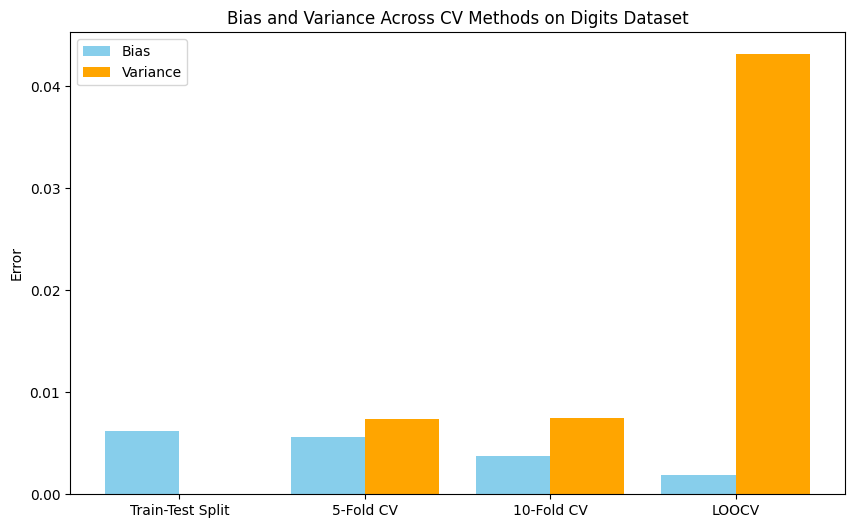

             Method      Bias  Variance
0  Train-Test Split  0.006173  0.000000
1         5-Fold CV  0.005573  0.007416
2        10-Fold CV  0.003739  0.007478
3             LOOCV  0.001862  0.043113


In [ ]:
#Digits : one versus rest

data = load_digits(n_class=3, return_X_y=True)

# Features and target variable
X, y = data

# Standard Scaler
scaler = StandardScaler()

# Scaling the features
X_scaled = scaler.fit_transform(X)

# Defining Logistic Regression model
LogReg = LogisticRegression(solver='lbfgs', max_iter=1000)

# Storing results for bias and variance
results = {'Method': [], 'Bias': [], 'Variance': []}

# Train-Test Split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=15)
LogReg.fit(X_train, y_train)
test_accuracy = LogReg.score(X_test, y_test)
results['Method'].append('Train-Test Split')
results['Bias'].append(1 - test_accuracy)  # Error = 1 - accuracy
results['Variance'].append(0)

# 5-Fold Cross-Validation
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
scores_5fold = cross_val_score(LogReg, X_scaled, y, cv=kf5)
results['Method'].append('5-Fold CV')
results['Bias'].append(1 - scores_5fold.mean())
results['Variance'].append(scores_5fold.std())

# 10-Fold Cross-Validation
kf10 = KFold(n_splits=10, shuffle=True, random_state=42)
scores_10fold = cross_val_score(LogReg, X_scaled, y, cv=kf10)
results['Method'].append('10-Fold CV')
results['Bias'].append(1 - scores_10fold.mean())
results['Variance'].append(scores_10fold.std())

# Leave-One-Out Cross-Validation (LOOCV)
loo = LeaveOneOut()
scores_loo = cross_val_score(LogReg, X_scaled, y, cv=loo)
results['Method'].append('LOOCV')
results['Bias'].append(1 - scores_loo.mean())
results['Variance'].append(scores_loo.std())

# Converting results to DataFrame
results_df = pd.DataFrame(results)

# Plotting bias and variance
plt.figure(figsize=(10, 6))
x = np.arange(len(results['Method']))
width = 0.4
plt.bar(x - width/2, results['Bias'], width, label='Bias', color='skyblue')
plt.bar(x + width/2, results['Variance'], width, label='Variance', color='orange')
plt.xticks(x, results['Method'])
plt.ylabel('Error')
plt.title('Bias and Variance Across CV Methods on Digits Dataset')
plt.legend()
plt.show()

# Displaying results
print(results_df)


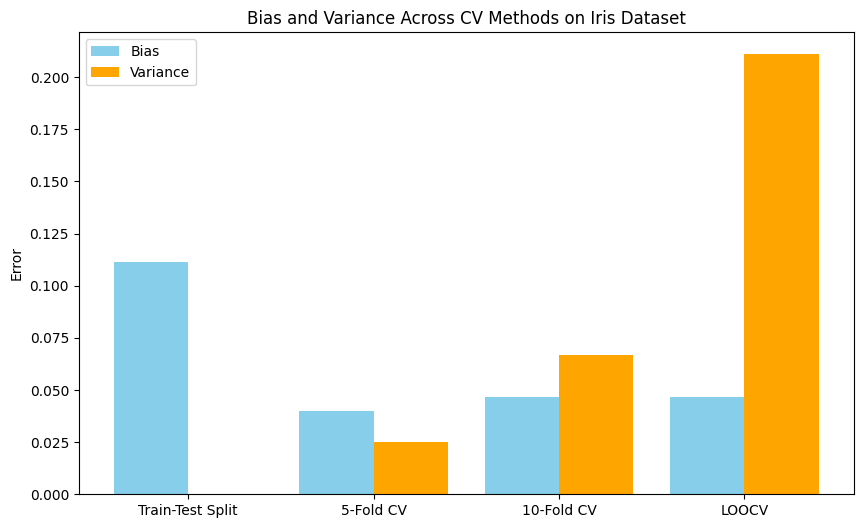

             Method      Bias  Variance
0  Train-Test Split  0.111111  0.000000
1         5-Fold CV  0.040000  0.024944
2        10-Fold CV  0.046667  0.066999
3             LOOCV  0.046667  0.210924


In [ ]:
#Iris dataset
data = load_iris(return_X_y=True)

# Features and target variable
X, y = data

# Standard Scaler
scaler = StandardScaler()

# Scaling the features
X_scaled = scaler.fit_transform(X)

# Defining Logistic Regression model
LogReg = LogisticRegression(solver='lbfgs', max_iter=1000)

# Storing results for bias and variance
results = {'Method': [], 'Bias': [], 'Variance': []}

# Train-Test Split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=11)
LogReg.fit(X_train, y_train)
test_accuracy = LogReg.score(X_test, y_test)
results['Method'].append('Train-Test Split')
results['Bias'].append(1 - test_accuracy)  # Error = 1 - accuracy
results['Variance'].append(0)

# 5-Fold Cross-Validation
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
scores_5fold = cross_val_score(LogReg, X_scaled, y, cv=kf5)
results['Method'].append('5-Fold CV')
results['Bias'].append(1 - scores_5fold.mean())
results['Variance'].append(scores_5fold.std())

# 10-Fold Cross-Validation
kf10 = KFold(n_splits=10, shuffle=True, random_state=42)
scores_10fold = cross_val_score(LogReg, X_scaled, y, cv=kf10)
results['Method'].append('10-Fold CV')
results['Bias'].append(1 - scores_10fold.mean())
results['Variance'].append(scores_10fold.std())

# Leave-One-Out Cross-Validation (LOOCV)
loo = LeaveOneOut()
scores_loo = cross_val_score(LogReg, X_scaled, y, cv=loo)
results['Method'].append('LOOCV')
results['Bias'].append(1 - scores_loo.mean())
results['Variance'].append(scores_loo.std())

# Converting results to DataFrame
results_df = pd.DataFrame(results)

# Plotting bias and variance
plt.figure(figsize=(10, 6))
x = np.arange(len(results['Method']))
width = 0.4
plt.bar(x - width/2, results['Bias'], width, label='Bias', color='skyblue')
plt.bar(x + width/2, results['Variance'], width, label='Variance', color='orange')
plt.xticks(x, results['Method'])
plt.ylabel('Error')
plt.title('Bias and Variance Across CV Methods on Iris Dataset')
plt.legend()
plt.show()

# Displaying results
print(results_df)


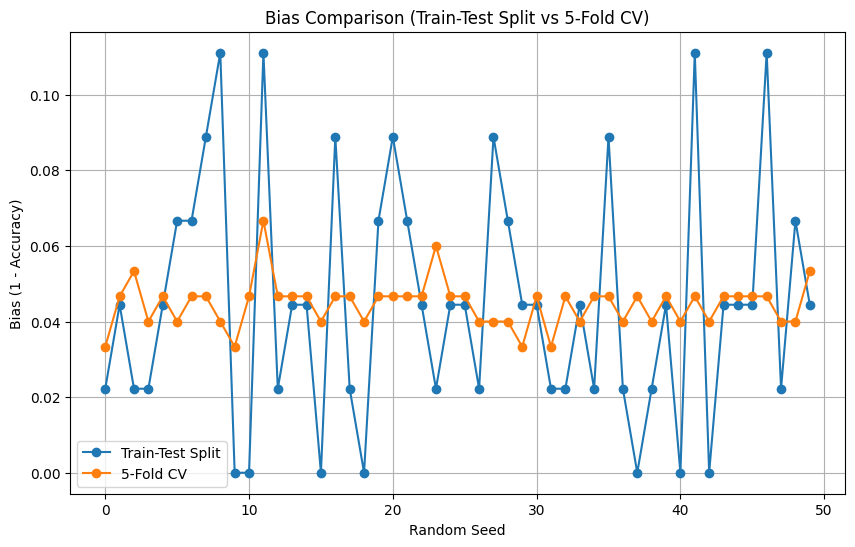

    Seed            Method      Bias
0      0  Train-Test Split  0.022222
1      1  Train-Test Split  0.044444
2      2  Train-Test Split  0.022222
3      3  Train-Test Split  0.022222
4      4  Train-Test Split  0.044444
5      5  Train-Test Split  0.066667
6      6  Train-Test Split  0.066667
7      7  Train-Test Split  0.088889
8      8  Train-Test Split  0.111111
9      9  Train-Test Split  0.000000
10    10  Train-Test Split  0.000000
11    11  Train-Test Split  0.111111
12    12  Train-Test Split  0.022222
13    13  Train-Test Split  0.044444
14    14  Train-Test Split  0.044444
15    15  Train-Test Split  0.000000
16    16  Train-Test Split  0.088889
17    17  Train-Test Split  0.022222
18    18  Train-Test Split  0.000000
19    19  Train-Test Split  0.066667
20    20  Train-Test Split  0.088889
21    21  Train-Test Split  0.066667
22    22  Train-Test Split  0.044444
23    23  Train-Test Split  0.022222
24    24  Train-Test Split  0.044444
25    25  Train-Test Split  0.044444
2

In [ ]:
def evaluate_model(X, y, model, seeds, method='train_test_split'):
    results = {'Seed': [], 'Method': [], 'Bias': []}

    for seed in seeds:
        if method == 'train_test_split':
            # Train-Test Split (70/30)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
            model.fit(X_train, y_train)
            test_accuracy = model.score(X_test, y_test)
            bias = 1 - test_accuracy
            results['Seed'].append(seed)
            results['Method'].append('Train-Test Split')
            results['Bias'].append(bias)

        elif method == '5_fold_cv':
            # 5-Fold Cross-Validation
            kf5 = KFold(n_splits=5, shuffle=True, random_state=seed)
            scores = cross_val_score(model, X, y, cv=kf5)
            bias = 1 - scores.mean()
            results['Seed'].append(seed)
            results['Method'].append('5-Fold CV')
            results['Bias'].append(bias)

    return results

# Loading Iris dataset
data = load_iris(return_X_y=True)
X, y = data

# Standard Scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Defining Logistic Regression model
LogReg = LogisticRegression(solver='lbfgs', max_iter=1000)

# Random seeds to test
seeds = list(range(0, 50))


# Evaluating the model using both methods
results_train_test = evaluate_model(X_scaled, y, LogReg, seeds, method='train_test_split')
results_5fold = evaluate_model(X_scaled, y, LogReg, seeds, method='5_fold_cv')

# Combining the results into a single DataFrame
results_df = pd.DataFrame(results_train_test)
results_df_5fold = pd.DataFrame(results_5fold)

# Concatenating both results into one
final_results = pd.concat([results_df, results_df_5fold], axis=0)

# Plotting Bias Comparison
plt.figure(figsize=(10, 6))
for method in final_results['Method'].unique():
    method_data = final_results[final_results['Method'] == method]
    plt.plot(method_data['Seed'], method_data['Bias'], label=method, marker='o')

plt.title('Bias Comparison (Train-Test Split vs 5-Fold CV)')
plt.xlabel('Random Seed')
plt.ylabel('Bias (1 - Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

# Displaying results
print(final_results)


# Overfitting detection and mitigation on Random Forest

In [ ]:
# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

# metadata
print(adult.metadata)

# variable information
print(adult.variables)

print(f"\n\nValue Count of label {y.value_counts()}")


{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [ ]:
# Combine X and y into one DataFrame
df_combined = pd.concat([X, y], axis=1)
print(df_combined.isna().sum())
# Drop rows with missing values (NaN)
df_combined_clean = df_combined.dropna()

# Separate the cleaned DataFrame back into X (features) and y (target)
X = df_combined_clean.drop(columns='income')  # Drop the 'income' column to get X
y = df_combined_clean['income']  # Extract the 'income' column to get y

print(f"\n\nX and y have 0 null values: ")
print(X.isna().sum())
print(y.isna().sum())

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64


X and y have 0 null values: 
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64
0


In [ ]:

print(f"\n Feature dimensions are: {X.shape}")
print(f"\n Label dimensions are: {y.shape}")


 Feature dimensions are: (47621, 14)

 Label dimensions are: (47621,)


In [ ]:
# Replace '<=50K.' with '<=50K' across the entire DataFrame to have consistency
y.replace('<=50K.', '<=50K', inplace=True)
y.replace('>50K.', '>50K', inplace=True)
print(y.value_counts())  ### imbalanced data

income
<=50K    36080
>50K     11541
Name: count, dtype: int64


In [ ]:
print(X.dtypes)
print(f"\n\n {X.head()}")

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object


    age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleane

In [ ]:

# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

print(f"categorical features are: {categorical_columns.tolist()}")
print(f"\nnumerical features are: {numerical_columns.tolist()}")

categorical features are: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

numerical features are: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [ ]:
# Get the number of unique categories (values) in each column
category_counts = X[categorical_columns].nunique()
print(category_counts)

workclass          9
education         16
marital-status     7
occupation        15
relationship       6
race               5
sex                2
native-country    42
dtype: int64


In [ ]:
# Apply manual label encoding to 'education' based on a predefined mapping
education_order = {
    'Preschool': 1,
    '1st-4th': 2,
    '5th-6th': 3,
    '7th-8th': 4,
    '9th': 5,
    '10th': 6,
    '11th': 7,
    '12th': 8,
    'HS-grad': 9,
    'Some-college': 10,
    'Assoc-acdm': 11,
    'Assoc-voc': 12,
    'Bachelors': 13,
    'Masters': 14,
    'Doctorate': 15,
    'Prof-school': 16
}

X['education'] = X['education'].map(education_order)
# Fill missing values in 'education' with a default value,i.e. 0 or any other value
X['education'].fillna(0, inplace=True)

# Label Encoding for binary column
label_encoder = LabelEncoder()
X['sex'] = label_encoder.fit_transform(X['sex'])

# One-Hot Encoding for low cardinality columns
X = pd.get_dummies(X, columns=['workclass', 'marital-status', 'race', 'relationship'], drop_first=True)

# Alternatively, use Frequency Encoding as opposed to One-hot encoding for high cardinality features
# (i.e. those that have too many unique categories)
X['occupation'] = X['occupation'].map(X['occupation'].value_counts() / len(X))
X['native-country'] = X['native-country'].map(X['native-country'].value_counts() / len(X))


y = y.map({'<=50K': 0, '>50K': 1})  # Map string labels to numeric values





In [ ]:
print(f"feature data types are:\n{X.dtypes}\n\n")
print(f"label data type is: {y.dtype}\n\n")

feature data types are:
age                                       int64
fnlwgt                                    int64
education                                 int64
education-num                             int64
occupation                              float64
sex                                       int64
capital-gain                              int64
capital-loss                              int64
hours-per-week                            int64
native-country                          float64
workclass_Federal-gov                      bool
workclass_Local-gov                        bool
workclass_Never-worked                     bool
workclass_Private                          bool
workclass_Self-emp-inc                     bool
workclass_Self-emp-not-inc                 bool
workclass_State-gov                        bool
workclass_Without-pay                      bool
marital-status_Married-AF-spouse           bool
marital-status_Married-civ-spouse          bool
marital-status_M

In [ ]:
# Get all boolean type columns
boolean_columns = X.select_dtypes(include=['bool'])
# Convert all boolean type columns to integers (1/0) in place
X[boolean_columns.columns] = boolean_columns.astype(int)


In [ ]:
print(X.dtypes)
print(f"\n\nAfter encodings the feature cols are transformed to:\n{X.columns.to_list()}")

age                                       int64
fnlwgt                                    int64
education                                 int64
education-num                             int64
occupation                              float64
sex                                       int64
capital-gain                              int64
capital-loss                              int64
hours-per-week                            int64
native-country                          float64
workclass_Federal-gov                     int64
workclass_Local-gov                       int64
workclass_Never-worked                    int64
workclass_Private                         int64
workclass_Self-emp-inc                    int64
workclass_Self-emp-not-inc                int64
workclass_State-gov                       int64
workclass_Without-pay                     int64
marital-status_Married-AF-spouse          int64
marital-status_Married-civ-spouse         int64
marital-status_Married-spouse-absent    

In [ ]:
#  Split the Data into Train and Test Sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
print(f"training data size: {X_tr.shape}")
print(f"\ntesting data size: {X_test.shape}")
print(f"\ntraining label size: {y_tr.shape}")
print(f"\ntesting label size: {y_test.shape}")

training data size: (38096, 33)

testing data size: (9525, 33)

training label size: (38096,)

testing label size: (9525,)


In [ ]:

# Random Forest Model with default parameters
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_tr, y_tr)

# Make predictions on both training and test sets
train_predictions = model_rf.predict(X_tr)
test_predictions = model_rf.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_tr, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print('Training Accuracy:', train_accuracy)
print('Testing Accuracy:', test_accuracy)
print("Classification Report:\n", classification_report(y_test, test_predictions))

Training Accuracy: 0.9998687526249475
Testing Accuracy: 0.8515485564304462
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      7170
           1       0.75      0.60      0.67      2355

    accuracy                           0.85      9525
   macro avg       0.81      0.77      0.79      9525
weighted avg       0.85      0.85      0.85      9525



In [ ]:
print(y_tr.value_counts())  ## training data was imbalanced

income
0    28910
1     9186
Name: count, dtype: int64



**Training Accuracy: 0.9998 (99.98%)**
This means the Random Forest model fits the training data almost perfectly.
Possible Concern: Such a high accuracy (near 100%) on training data suggests the model might be overfitting — it has "memorized" the training data instead of generalizing patterns.

**Testing Accuracy:** 0.8515 (85.15%) The model achieves 85.15% accuracy on unseen test data. This is the measure of how well the model generalizes to new data. The drop from 99.98% (training) to 85.15% (testing) confirms some degree of overfitting.

**Metrics for <=50K Class:**
Precision: 0.88 → Of all the predictions the model made as <=50K, 88% were correct.
Recall: 0.93 → Of all the actual <=50K instances, 93% were correctly predicted.
F1-Score: 0.90 → Combines precision and recall into a single score.
This class is performing well because it has high precision, recall, and f1-score.

**Metrics for >50K Class:**
Precision: 0.75 → Of all the predictions the model made as >50K, 75% were correct.
Recall: 0.60 → Of all the actual >50K instances, only 60% were correctly predicted.
F1-Score: 0.67 → A lower score due to reduced recall.
The model struggles with the >50K class, which might indicate:

Class imbalance: There are fewer examples of >50K (support = 2355) compared to <=50K (support = 7170).
Bias: The model may favor the dominant class (<=50K).


# Conclusion

**Class Imbalance:** The model is struggling more with the minority class (>50K). This is typical for imbalanced datasets. You can improve performance by:

**Resampling:** Use techniques like SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic examples of the minority class.

**Class weights**: We can adjust the class weights during model training to make the model pay more attention to the minority class. This can be done with Random Forest by setting class_weight='balanced'.

**Overfitting:** The model shows very high accuracy on the training set but much lower accuracy on the validation and test sets. This indicates overfitting, meaning the model is too complex or not generalizing well. You can address this by:

**Pruning**: Apply pruning to limit the depth of trees in the Random Forest.

**Regularization:** We can improve the model's generalization by adjusting/tuning the model via tweaking hyperparameters like max_depth, n_estimators, min_samples_split, and min_samples_leaf.


n_estimators: The number of trees in the Random Forest.

max_depth: The maximum depth of each tree.

min_samples_split and min_samples_leaf: Controls for stopping the growth of trees.

**Cross-validation:** Use cross-validation to get a better estimate of model performance and avoid overfitting.

In [ ]:
# Balance class distribution using SMOTE (Only on training data)
smote = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=5, n_jobs=-1)
X_train, y_train = smote.fit_resample(X_tr, y_tr)

print(f"Oversampled train data: {y_train.value_counts()}")

# Define Hyperparameter Grid for Random Forest
param_grid = {
    'n_estimators': [40, 50, 60, 70],          # Number of trees
    'max_depth': [5, 10, 15],         # Tree depth
    'min_samples_split': [200, 300, 400],        # Minimum samples to split
    'min_samples_leaf': [20, 50, 100],      # Minimum samples at a leaf
    'class_weight': ['balanced']         # Handle class imbalance
}

# Define multiple scorers
scorers = {
    'precision': make_scorer(precision_score, average='weighted', zero_division=1),
    'recall': make_scorer(recall_score, average='weighted', zero_division=1),
    'f1': make_scorer(f1_score, average='weighted', zero_division=1),
    'accuracy': make_scorer(accuracy_score)
}





Oversampled train data: income
0    28910
1    28910
Name: count, dtype: int64


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

(57820, 33)
(9525, 33)
income
0    28910
1    28910
Name: count, dtype: int64
income
0    7170
1    2355
Name: count, dtype: int64


In [ ]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Set up GridSearchCV with Random Forest Classifier
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=skf,
    scoring=scorers,
    refit='f1',
    verbose=2,
    n_jobs=-1
)

# Train the Model with GridSearchCV
print("Starting Grid Search for Hyperparameter Tuning...")
grid_search.fit(X_train, y_train)

print(f"\nBest Hyperparameters: {grid_search.best_params_}")
print("Best F1 Score:", grid_search.best_score_)

# Evaluate Best Model from Grid Search
best_rf_model = grid_search.best_estimator_

Starting Grid Search for Hyperparameter Tuning...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 20, 'min_samples_split': 200, 'n_estimators': 70}
Best F1 Score: 0.8804647701620854


In [ ]:
y_pred_train = best_rf_model.predict(X_train)
y_pred_test = best_rf_model.predict(X_test)


# Calculate Accuracy and Classification Report
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"\nTesting Accuracy: {train_accuracy:.4f}")
print(f"\nTesting Accuracy: {test_accuracy:.4f}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Cross-Validation Score for the Best Model
cv_results = cross_validate(best_rf_model, X_train, y_train, cv=5, scoring=scorers)

# Print the scores for each fold
print("Cross-Validation Results:")
print("Accuracy Scores:", cv_results['test_accuracy'])
print("Precision Scores:", cv_results['test_precision'])
print("Recall Scores:", cv_results['test_recall'])
print("F1 Scores:", cv_results['test_f1'])




Testing Accuracy: 0.8827

Testing Accuracy: 0.8321

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.88      7170
           1       0.63      0.76      0.69      2355

    accuracy                           0.83      9525
   macro avg       0.77      0.81      0.79      9525
weighted avg       0.85      0.83      0.84      9525

Cross-Validation Results:
Accuracy Scores: [0.79064338 0.85117606 0.90003459 0.90755794 0.90539606]
Precision Scores: [0.80311872 0.85182855 0.90710526 0.91440087 0.91199938]
Recall Scores: [0.79064338 0.85117606 0.90003459 0.90755794 0.90539606]
F1 Scores: [0.78846688 0.85110703 0.89959864 0.90717474 0.90501547]


## Conclusion

We see that the gap between train and test accuracies has shrinked and the model does not overfit anymore.
The cross-validation accuracy scores are quite consistent (values like 0.79, 0.77, 0.78, etc.), similarly other CV metrics also show small variations indicating that the model is stabilized. This shows that the model is performing similarly across different folds and is generalizing well on the validation data.

# Model Interpretability

In [ ]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    """
    Encodes categorical features based on their frequency in the dataset.

    This class transforms categorical columns by replacing each category with its
    relative frequency within the column.  This can be useful for machine learning
    algorithms that don't handle categorical data directly.  Missing values are
    replaced with 0.

    Parameters:
    -----------
    columns : list
        A list of column names to encode.

    Attributes:
    -----------
    freq_dict_ : dict
        A dictionary storing the frequency of each category for each specified column.
    """
    def __init__(self, columns):
        self.columns = columns
        self.freq_dict_ = {}

    def fit(self, X, y=None):
        """
        Learns the frequency of each category for each specified column.

        Parameters:
        -----------
        X : pandas.DataFrame
            The input data.
        y : array-like, default=None
            Target values (not used in this encoder).

        Returns:
        --------
        self : object
        """
        for col in self.columns:
            self.freq_dict_[col] = X[col].value_counts(normalize=True)
        return self

    def transform(self, X):
        """
        Transforms the input data by replacing categories with their frequencies.

        Parameters:
        -----------
        X : pandas.DataFrame
            The input data to transform.

        Returns:
        --------
        pandas.DataFrame
            The transformed data with encoded columns.
        """
        X = X.copy()
        for col in self.columns:
            X[col] = X[col].map(self.freq_dict_[col])
            X[col].fillna(0, inplace=True)
        return X

# Fetching Data
adult = fetch_ucirepo(id=2)
X = adult.data.features
y = adult.data.targets

if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]

# Encode target variable
y.replace({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1, '<=50K:': 0, '>50K:': 1}, inplace=True)

# Handle Missing Values
columns_to_impute = ['workclass', 'occupation']
for col in columns_to_impute:
    mask = X[col].isna()
    X.loc[mask, col] = (
        X.loc[~mask, col]
        .sample(n=mask.sum(), replace=True, random_state=42)
        .values
    )

# Column Groups
binary_cols = ['sex']
one_hot_cols = ['workclass', 'marital-status', 'relationship', 'race']
freq_cols = ['education', 'occupation', 'native-country']
numerical_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


missing_onehot = [col for col in one_hot_cols if col not in X.columns]
missing_binary = [col for col in binary_cols if col not in X.columns]
missing_freq = [col for col in freq_cols if col not in X.columns]
missing_numerical = [col for col in numerical_cols if col not in X.columns]


# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False), one_hot_cols),
        ('binary', OrdinalEncoder(), binary_cols),
        ('freq', 'passthrough', freq_cols),
        ('numerical', 'passthrough', numerical_cols)
    ],
    remainder='drop'
)

# Complete Pipeline
pipeline = Pipeline(steps=[
    ('frequency_encoding', FrequencyEncoder(columns=freq_cols)),
    ('preprocessing', preprocessor)
])

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit Pipeline
pipeline.fit(X_train, y_train)

# Transform Data
X_train_transformed = pipeline.transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# If still sparse, convert to dense:
if hasattr(X_train_transformed, 'toarray'):
    X_train_transformed = X_train_transformed.toarray()
if hasattr(X_test_transformed, 'toarray'):
    X_test_transformed = X_test_transformed.toarray()


# Retrieve Feature Names
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()

# Create DataFrames
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names, index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names, index=X_test.index)

X_train = X_train_transformed_df.copy()
X_test = X_test_transformed_df.copy()


## Case 1 NN first try

Epoch 1/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6934 - auc: 0.5786 - loss: 1.4555 - val_accuracy: 0.7927 - val_auc: 0.5983 - val_loss: 0.6744 - learning_rate: 0.0010
Epoch 2/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7789 - auc: 0.5930 - loss: 0.6467 - val_accuracy: 0.7849 - val_auc: 0.5887 - val_loss: 0.5511 - learning_rate: 0.0010
Epoch 3/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7885 - auc: 0.6074 - loss: 0.5419 - val_accuracy: 0.7817 - val_auc: 0.5985 - val_loss: 0.5314 - learning_rate: 0.0010
Epoch 4/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7867 - auc: 0.6060 - loss: 0.5296 - val_accuracy: 0.7930 - val_auc: 0.6149 - val_loss: 0.5200 - learning_rate: 0.0010
Epoch 5/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7843 - auc: 0.6209 - loss: 0.5263 - val_accuracy: 0.7873 - val_auc: 0.6179 - val_loss: 0.5208 - learning_rate: 0.0010
Epoch 6/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7867 - a

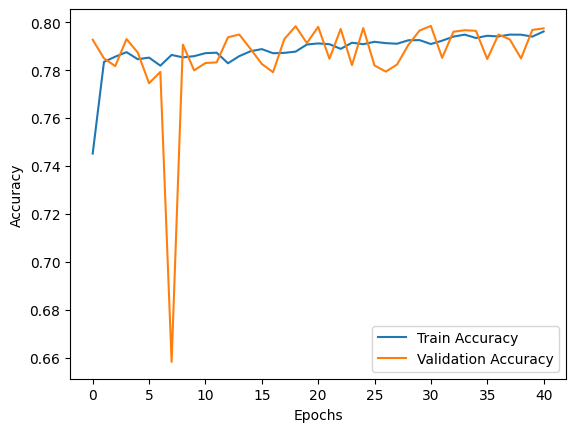

In [ ]:

input_dim = X_train.shape[1]

def build_optimized_model(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=input_dim, kernel_regularizer='l2'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer='l2'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

model = build_optimized_model(input_dim)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_schedule],
    verbose=1
)

# Evaluate
test_loss, test_accuracy, test_auc = model.evaluate(X_test_transformed, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test AUC: {test_auc:.2f}")

# Classification Report
y_pred = (model.predict(X_test_transformed) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

# Training History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Case 2 CatBoost

[I 2024-12-21 13:26:59,062] A new study created in memory with name: no-name-5714a4d4-aec8-4a44-9bab-5ea0c7847180
[I 2024-12-21 13:28:12,849] Trial 0 finished with value: 0.8714200851171701 and parameters: {'iterations': 823, 'depth': 8, 'learning_rate': 0.29334283621007584, 'l2_leaf_reg': 2.858946961754229, 'border_count': 208, 'bagging_temperature': 0.1667569440175869, 'random_strength': 16.14922303756778}. Best is trial 0 with value: 0.8714200851171701.
[I 2024-12-21 13:33:08,249] Trial 1 finished with value: 0.8735187478680997 and parameters: {'iterations': 1961, 'depth': 4, 'learning_rate': 0.06518014113994602, 'l2_leaf_reg': 9.124519255857708, 'border_count': 61, 'bagging_temperature': 0.40671637187244825, 'random_strength': 5.598376516586058}. Best is trial 1 with value: 0.8735187478680997.
[I 2024-12-21 13:34:24,904] Trial 2 finished with value: 0.8735699707908161 and parameters: {'iterations': 1484, 'depth': 5, 'learning_rate': 0.26908815926895424, 'l2_leaf_reg': 4.38549089929

0:	learn: 0.6727722	total: 70.9ms	remaining: 1m 37s
100:	learn: 0.3959029	total: 6.12s	remaining: 1m 17s
200:	learn: 0.3816654	total: 13s	remaining: 1m 16s
300:	learn: 0.3660811	total: 19.6s	remaining: 1m 10s
400:	learn: 0.3350175	total: 29s	remaining: 1m 10s
500:	learn: 0.3254230	total: 36.2s	remaining: 1m 3s
600:	learn: 0.3190814	total: 45.4s	remaining: 58.8s
700:	learn: 0.3145205	total: 53.4s	remaining: 51.7s
800:	learn: 0.3099079	total: 1m 1s	remaining: 44.6s
900:	learn: 0.3056268	total: 1m 11s	remaining: 37.8s
1000:	learn: 0.3014531	total: 1m 18s	remaining: 29.9s
1100:	learn: 0.2979234	total: 1m 28s	remaining: 22.4s
1200:	learn: 0.2948777	total: 1m 37s	remaining: 14.5s
1300:	learn: 0.2916514	total: 1m 44s	remaining: 6.37s
1379:	learn: 0.2892852	total: 1m 52s	remaining: 0us
Accuracy: 0.84
              precision    recall  f1-score   support

       <=50K       0.94      0.84      0.89      7431
        >50K       0.63      0.84      0.72      2338

    accuracy                    

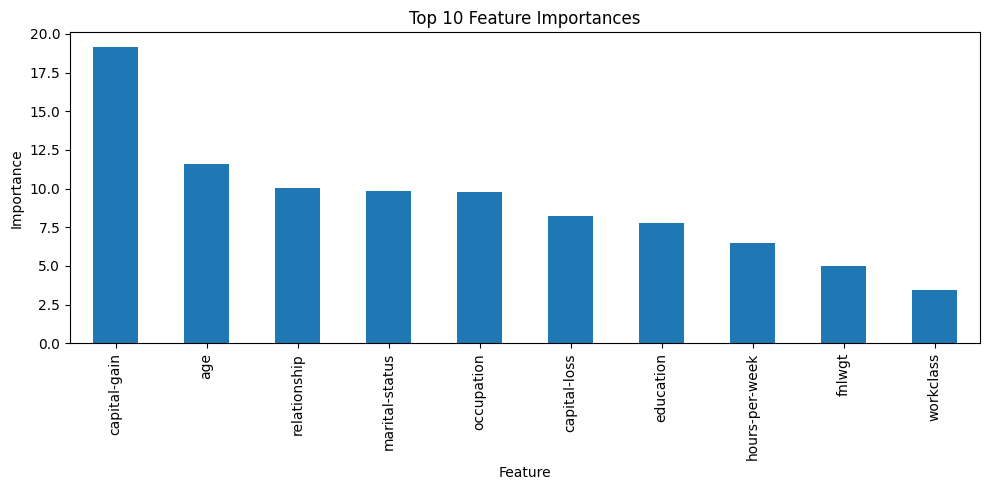

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier
import optuna
import matplotlib.pyplot as plt

# Fetch the dataset
adult = fetch_ucirepo(id=2)
X = adult.data.features
y = adult.data.targets

# Fixing misspelling in the target variable
y = y.replace({'<=50K.': '<=50K', '>50K.': '>50K'})

# Identify categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Handle missing values in categorical features
X[categorical_features] = X[categorical_features].fillna('Missing')
X[categorical_features] = X[categorical_features].astype(str)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define an Optuna objective function
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 256),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1, 20),
        'verbose': 0
    }
    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_index, val_index in kf.split(X_train):
        X_t, X_v = X_train.iloc[train_index], X_train.iloc[val_index]
        y_t, y_v = y_train.iloc[train_index], y_train.iloc[val_index]

        X_t[categorical_features] = X_t[categorical_features].fillna('Missing').astype(str)
        X_v[categorical_features] = X_v[categorical_features].fillna('Missing').astype(str)

        model = CatBoostClassifier(cat_features=categorical_features, **params)
        model.fit(X_t, y_t, eval_set=(X_v, y_v), early_stopping_rounds=50, verbose=0)
        preds = model.predict(X_v)
        scores.append(accuracy_score(y_v, preds))

    return np.mean(scores)

# Optimize hyperparameters with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Train the final model with best parameters
best_params = study.best_params
model_cat = CatBoostClassifier(class_weights=[1, 3],cat_features=categorical_features, **best_params, verbose=100)
model_cat.fit(X_train, y_train)

# Evaluate the model
y_pred = model_cat.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# Feature importance visualization
feature_importances = pd.DataFrame({
    'Feature': model_cat.feature_names_,
    'Importance': model_cat.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances.head(10))

feature_importances.head(10).plot.bar(
    x='Feature',
    y='Importance',
    legend=False,
    figsize=(10, 5)
)
plt.title("Top 10 Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
# Predicted probabilities for the test set
y_pred_proba = model_cat.predict_proba(X_test)

# Custom threshold
custom_threshold = 0.68
# Convertted probabilities to class labels based on the custom threshold
y_pred_custom = (y_pred_proba[:, 1] >= custom_threshold).astype(int)

# Mapped the binary labels (0/1) to the original target labels
label_mapping = {k: v for k, v in enumerate(model_cat.classes_)}
y_pred_custom = pd.Series(y_pred_custom).map(label_mapping)

# Evaluated the model with the custom threshold
print(f"Accuracy (Custom Threshold): {accuracy_score(y_test, y_pred_custom):.2f}")
print(classification_report(y_test, y_pred_custom))


Accuracy (Custom Threshold): 0.88
              precision    recall  f1-score   support

       <=50K       0.91      0.92      0.92      7431
        >50K       0.75      0.72      0.73      2338

    accuracy                           0.88      9769
   macro avg       0.83      0.82      0.83      9769
weighted avg       0.87      0.88      0.87      9769



## Case 3:  Improved NN approach with other preprocessing pipeline

Epoch 1/100
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8009 - loss: 0.4376 - val_accuracy: 0.8308 - val_loss: 0.3670 - learning_rate: 0.0010
Epoch 2/100
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8266 - loss: 0.3813 - val_accuracy: 0.8328 - val_loss: 0.3621 - learning_rate: 0.0010
Epoch 3/100
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8330 - loss: 0.3711 - val_accuracy: 0.8359 - val_loss: 0.3632 - learning_rate: 0.0010
Epoch 4/100
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8391 - loss: 0.3641 - val_accuracy: 0.8384 - val_loss: 0.3573 - learning_rate: 0.0010
Epoch 5/100
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8316 - loss: 0.3695 - val_accuracy: 0.8399 - val_loss: 0.3547 - learning_rate: 0.0010
Epoch 6/100
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8410 - loss: 0.3572 - val_accuracy: 0.8366 - val_loss: 0.3575 - learning_rate: 0.0010
Epoch 7/100
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      7494
           1       0.85      0.86      0.85      7368

    accuracy                           0.85     14862
   macro avg       0.85      0.85      0.85     14862
weighted avg       0.85      0.85      0.85     14862



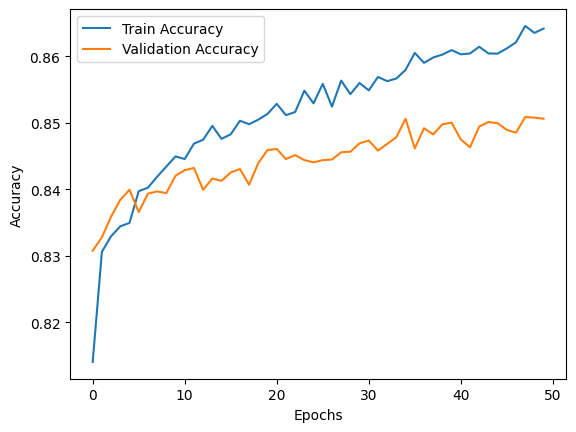

In [ ]:
# Fetching the dataset
adult = fetch_ucirepo(id=2)
X = adult.data.features
y = adult.data.targets

# Fixing misspelling in the target variable
y = y.replace({'<=50K.': '<=50K', '>50K.': '>50K'})

# Encoding the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Handle missing values
X[categorical_columns] = X[categorical_columns].fillna(X[categorical_columns].mode().iloc[0])
X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].median())

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
    ]
)

# Preprocess the data
X_processed = preprocessor.fit_transform(X)

# Apply SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_processed, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
input_dim = X_train.shape[1]

# Build the optimized neural network
def build_optimized_model(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_dim=input_dim))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))  # Dropout to prevent overfitting
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
    return model

# Compile the model
model = build_optimized_model(input_dim)
model.compile(optimizer = optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-7,
    centered=False
),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Training with early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_schedule],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification report
y_pred = (model.predict(X_test) > 0.59).astype(int)
print(classification_report(y_test, y_pred))
model.save('optimized_nn_model.h5')
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




## SHAP Value Analysis

In [ ]:
# Feat SHAP
explainer = shap.Explainer(model, X_train)

# Evaluating SHAP values
shap_values = explainer(X_test)


# Save SHAP values
with open('shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)


cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
num_features = numeric_columns
feature_names = np.concatenate([num_features, cat_features])
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

model = load_model('optimized_nn_model.h5')

with open('shap_values.pkl', 'rb') as f:
    shap_values = pickle.load(f)

with open('feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)


PermutationExplainer explainer: 14863it [34:09,  7.25it/s]


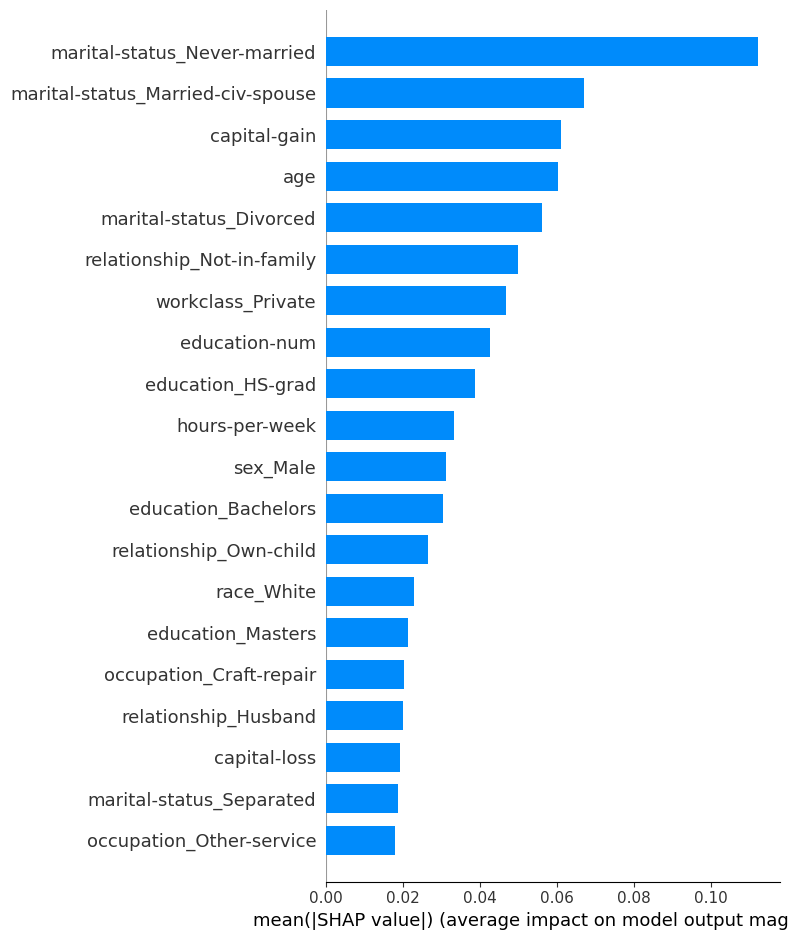

In [ ]:
# Feature Importance Plot
shap.summary_plot(shap_values, X_test, plot_type='bar', feature_names=feature_names)


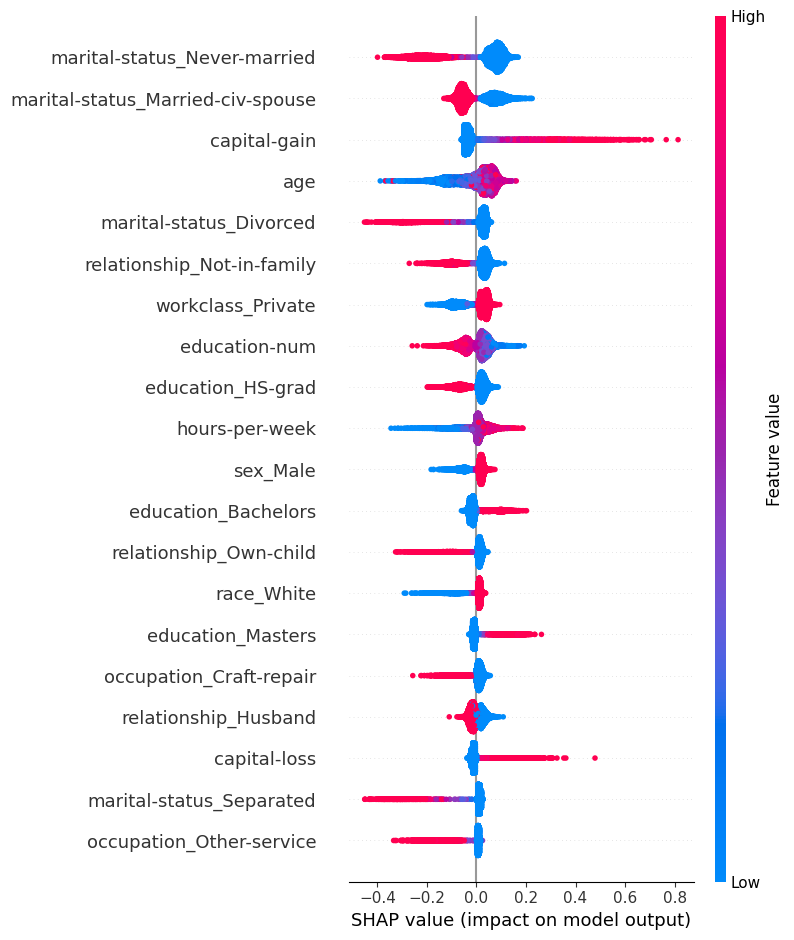

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

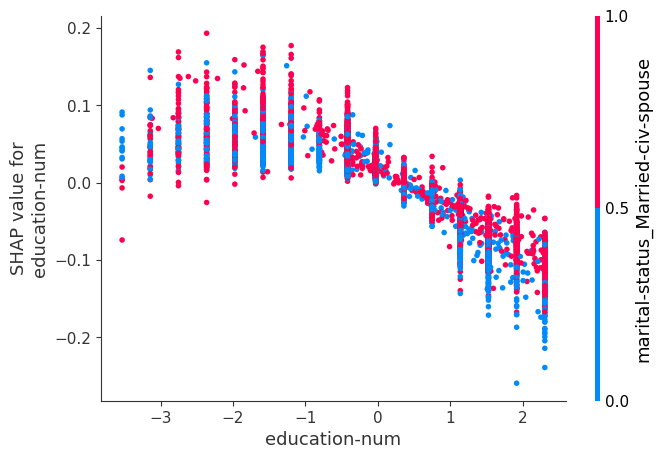

In [ ]:
shap.dependence_plot(
    'education-num',
    shap_values.values,
    X_test,
    feature_names=feature_names
)


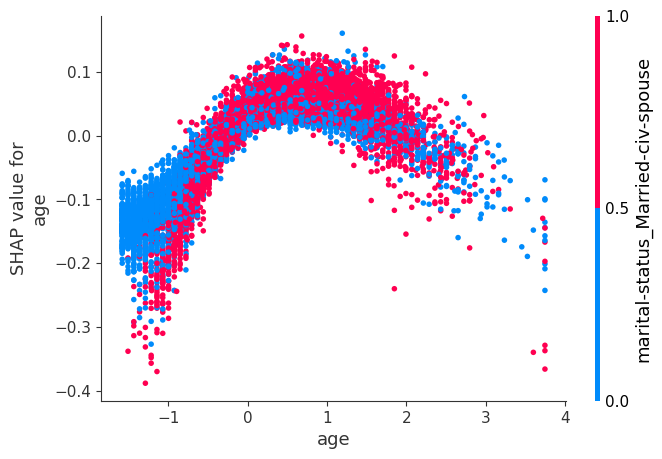

In [ ]:
shap.dependence_plot(0, shap_values.values, X_test,feature_names=feature_names)

In [ ]:
shap_values_array = shap_values.values
base_value = shap_values.base_values

In [ ]:
def shap_to_probability(base_value, shap_values):
    """
    Convert SHAP values (log-odds) into probabilities.

    Parameters:
    - base_value: The base log-odds prediction (expected value).
    - shap_values: NumPy array of SHAP values for features.

    Returns:
    - probabilities: Converted probabilities.
    """
    # Compute log-odds for each sample
    log_odds = base_value + shap_values.sum(axis=1)

    # Apply sigmoid to convert log-odds to probabilities
    probabilities = 1 / (1 + np.exp(-log_odds))

    return probabilities
#probability being class 1 | 50k$+
probabilities = shap_to_probability(base_value, shap_values_array)
print(probabilities[:10])

[[0.72067297 0.64715004 0.66250256 ... 0.50181308 0.7165082  0.52854921]
 [0.72067297 0.64715004 0.66250256 ... 0.50181308 0.7165082  0.52854921]
 [0.72067297 0.64715004 0.66250256 ... 0.50181308 0.7165082  0.52854921]
 ...
 [0.72067297 0.64715004 0.66250256 ... 0.50181308 0.7165082  0.52854921]
 [0.72067297 0.64715004 0.66250256 ... 0.50181308 0.7165082  0.52854921]
 [0.72067297 0.64715004 0.66250256 ... 0.50181308 0.7165082  0.52854921]]


In [ ]:
def shap_to_probability_changes(base_value, shap_values):
    """
    Computes the probability change caused by each feature for each observation.

    Parameters:
    - base_value: Base log-odds (expected value).
    - shap_values: NumPy array of SHAP values for features.

    Returns:
    - prob_changes_df: DataFrame showing probability changes per feature.
    """
    #  base probability
    base_prob = 1 / (1 + np.exp(-base_value))

    # Initialize log-odds and probabilities for each observation
    log_odds = base_value + shap_values.cumsum(axis=1)  # Cumulative sum for each feature
    probs = 1 / (1 + np.exp(-log_odds))  # Apply sigmoid function

    # Calculate probability changes for each feature
    base_prob_array = np.full((shap_values.shape[0], 1), base_prob)  # Match shape
    prob_changes = np.diff(probs, axis=1, prepend=base_prob_array)

    # Convert to DataFrame for easier interpretation
    prob_changes_df = pd.DataFrame(prob_changes, columns=feature_names)
    return prob_changes_df


shap_values_array = shap_values.values
feature_names = feature_names

# Calculate base value
pred_probs = model.predict(X_test)
mean_prob = np.mean(pred_probs)
base_value = np.log(mean_prob / (1 - mean_prob))  # Convert mean probability to log-odds

# Get probability changes caused by each feature
probability_changes = shap_to_probability_changes(base_value, shap_values_array)



465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [ ]:
# How for each observation each feature changes probabilty of being classified 1| 50k$ +
probability_changes

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,-0.000825,-0.000151,-0.012236,-0.006529,0.032314,-0.001040,0.000345,-0.000672,-0.000846,0.0,...,0.0,-0.000026,0.0,0.000181,0.0,0.0,0.0,0.001684,0.0,0.0
1,0.010891,0.000026,0.017490,-0.009554,-0.003640,0.007325,0.000039,-0.001067,-0.000154,0.0,...,0.0,-0.000021,0.0,0.000201,0.0,0.0,0.0,0.001380,0.0,0.0
2,0.007695,-0.000251,0.007275,-0.007646,-0.003579,0.015749,-0.000177,-0.001038,-0.000563,0.0,...,0.0,-0.000216,0.0,0.000459,0.0,0.0,0.0,0.002329,0.0,0.0
3,0.013475,-0.000968,0.001676,0.061307,-0.003803,0.003588,-0.000244,-0.000621,-0.000513,0.0,...,0.0,-0.000151,0.0,0.000320,0.0,0.0,0.0,0.001528,0.0,0.0
4,-0.000147,-0.000957,-0.022024,-0.010929,-0.003079,0.001324,0.000198,-0.000552,-0.000463,0.0,...,0.0,-0.000101,0.0,0.000112,0.0,0.0,0.0,0.001911,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14857,0.002009,0.000180,0.000016,-0.006900,-0.002673,0.004337,-0.000014,-0.000992,-0.000524,0.0,...,0.0,-0.000024,0.0,0.000248,0.0,0.0,0.0,0.001337,0.0,0.0
14858,0.013388,-0.001648,0.016308,-0.009889,-0.004927,0.005161,-0.000183,-0.000932,-0.000764,0.0,...,0.0,-0.000054,0.0,0.000105,0.0,0.0,0.0,0.001721,0.0,0.0
14859,-0.030552,0.000347,0.007784,-0.011401,-0.001727,-0.016110,0.000216,-0.000205,0.000031,0.0,...,0.0,0.000024,0.0,-0.000002,0.0,0.0,0.0,0.000034,0.0,0.0
14860,-0.016835,-0.004005,-0.016808,-0.005981,-0.003057,0.010305,0.000110,-0.000919,-0.000841,0.0,...,0.0,-0.000161,0.0,0.000351,0.0,0.0,0.0,0.002461,0.0,0.0


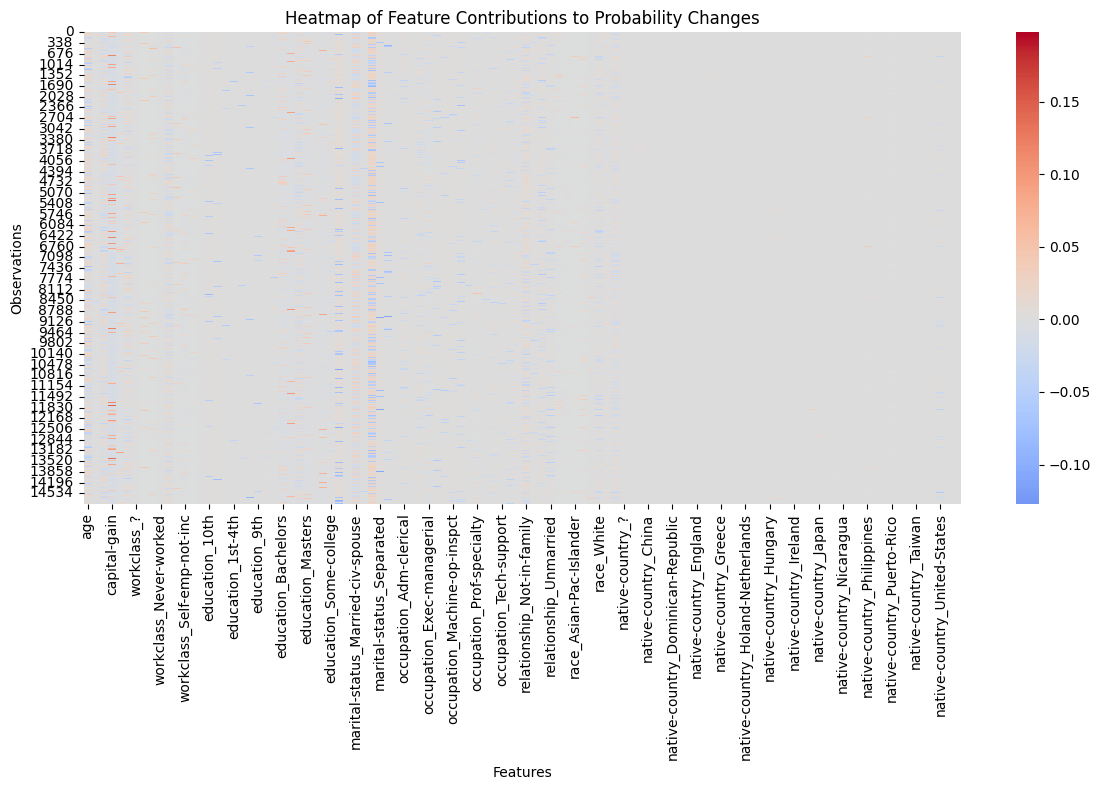

In [ ]:
import seaborn as sns

def plot_heatmap(probability_changes):
    """
    Heatmap to visualize probability changes for all observations.

    Parameters:
    - probability_changes: DataFrame with probability changes.
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(probability_changes, cmap='coolwarm', center=0, annot=False, fmt='.2f')
    plt.xlabel('Features')
    plt.ylabel('Observations')
    plt.title('Heatmap of Feature Contributions to Probability Changes')
    plt.tight_layout()
    plt.show()


plot_heatmap(probability_changes)


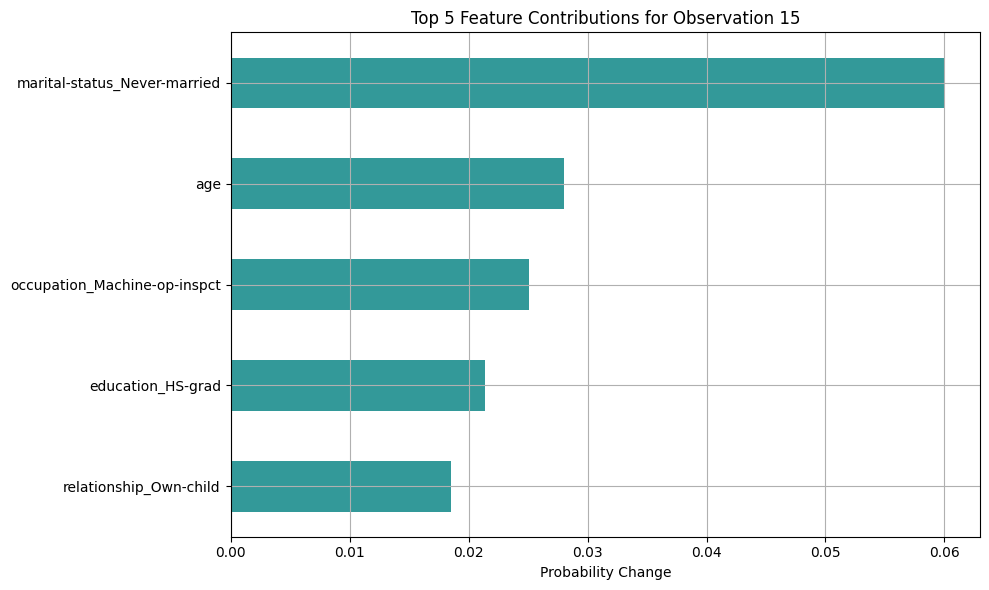

In [ ]:
def plot_top_k(probability_changes, observation_index, k=5):
    """
    Bar plot showing top-k features influencing probability for one observation.

    Parameters:
    - probability_changes: DataFrame with probability changes.
    - observation_index: Index of the observation to visualize.
    - k: Number of top features to display.
    """
    # Get probability changes for the selected observation
    obs_changes = probability_changes.iloc[observation_index]
    top_k = obs_changes.abs().sort_values(ascending=False).head(k)

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    top_k.sort_values().plot(kind='barh', color='teal', alpha=0.8)
    plt.xlabel('Probability Change')
    plt.title(f'Top {k} Feature Contributions for Observation {observation_index}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example: Top 5 features for Observation 15
plot_top_k(probability_changes, observation_index=15, k=5)


In [ ]:
def plot_top_k_bidirectional(probability_changes, observation_index, k=5, library='seaborn'):
    """
    Bar plot showing top-k features influencing probability (both positive and negative)
    for one observation.

    Parameters:
    - probability_changes: DataFrame with probability changes.
    - observation_index: Index of the observation to visualize.
    - k: Number of top features to display.
    - library: Visualization library to use ('seaborn' or 'plotly').
    """
    # Get probability changes for the selected observation
    obs_changes = probability_changes.iloc[observation_index]

    # Select top-k features considering both positive and negative contributions
    top_k = obs_changes.abs().nlargest(k).index
    top_k_values = obs_changes[top_k].sort_values()

    if library == 'seaborn':
        plt.figure(figsize=(10, 6))
        sns.barplot(x=top_k_values.values, y=top_k_values.index, palette=['red' if v < 0 else 'green' for v in top_k_values])
        plt.xlabel('Probability Change')
        plt.title(f'Top {k} Feature Contributions for Observation {observation_index}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    elif library == 'plotly':
        fig = px.bar(
            x=top_k_values.values,
            y=top_k_values.index,
            orientation='h',
            color=[v < 0 for v in top_k_values],
            color_discrete_map={True: 'red', False: 'green'},
            labels={'x': 'Probability Change', 'y': 'Features'},
            title=f'Top {k} Feature Contributions for Observation {observation_index}'
        )
        fig.update_layout(height=400, width=800)
        fig.show()

# Example: Top 5 features for Observation 15
# Correct function call
plot_top_k_bidirectional(probability_changes, observation_index=19, k=5, library='plotly')

